<a href="https://colab.research.google.com/github/amaluvincent/Fake-News-Detection/blob/main/Fake_news_detection_NLP_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Setting up the environment

In [42]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk
!pip install tensorflow keras
#!pip install lime

# 2.Importing libraraies

In [80]:
# import necessary libabaries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction, linear_model, model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from collections import Counter
#import shap
#from scipy.sparse import issparse
#from lime.lime_text import LimeTextExplainer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 3.Load dataset

In [44]:
# Load the ISOT dataset
true_news = pd.read_csv('/content/True.csv')
fake_news =  pd.read_csv('/content/Fake.csv')

# checking the size of each files
print('true:',true_news.shape)
print('fake:', fake_news.shape)


true: (21417, 4)
fake: (23481, 4)


# 4. Data cleaning and preparation

In [45]:
# Add a label to each dataframe
true_news['label'] = 0   # 0 for legitimate news
fake_news['label'] = 1   # 1 for fake news

# Combine both datasets
df = pd.concat([true_news, fake_news],ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)  # shuffle the data

# Print the combined dataset (first few rows)
print(df.head(5))
print(df.shape)



                                               title  \
0  “Would You Rather Do A Job You Hate And Not Pa...   
1  PORTLAND POLICE Call Violent Anti-Trump Protes...   
2  Wife of 'American Sniper' making waves in Texa...   
3  Trump threat to renegotiate U.N. climate deal ...   
4  WATCH: IRAN Made VIDEOTAPE Of Secret $400 Mill...   

                                                text          subject  \
0  Filmmaker and patriot, Dennis Michael Lynch is...  Government News   
1  Here s what the election map for Crooked Hilla...         politics   
2  FORT WORTH, Texas (Reuters) - The widow of a s...     politicsNews   
3  OSLO/WASHINGTON (Reuters) - Donald Trump’s vow...     politicsNews   
4  It s starting to get old but Trump was right a...  Government News   

                 date  label  
0        Feb 12, 2017      1  
1        Nov 11, 2016      1  
2  February 29, 2016       0  
3       May 18, 2016       0  
4         Aug 5, 2016      1  
(44898, 5)


In [46]:
# Check for missing values
print("Missing values in dataset:\n", df.isnull().sum())
df.dropna(inplace=True)  # Drop any rows with missing values

Missing values in dataset:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [47]:
# print dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


In [48]:
# Removing unnecessary column(date)
df = df.drop(columns=["date"])
print(df.head())

                                               title  \
0  “Would You Rather Do A Job You Hate And Not Pa...   
1  PORTLAND POLICE Call Violent Anti-Trump Protes...   
2  Wife of 'American Sniper' making waves in Texa...   
3  Trump threat to renegotiate U.N. climate deal ...   
4  WATCH: IRAN Made VIDEOTAPE Of Secret $400 Mill...   

                                                text          subject  label  
0  Filmmaker and patriot, Dennis Michael Lynch is...  Government News      1  
1  Here s what the election map for Crooked Hilla...         politics      1  
2  FORT WORTH, Texas (Reuters) - The widow of a s...     politicsNews      0  
3  OSLO/WASHINGTON (Reuters) - Donald Trump’s vow...     politicsNews      0  
4  It s starting to get old but Trump was right a...  Government News      1  


In [49]:
# Removing unnecessary column(title)
df = df.drop(columns=["title"])
print(df.head())

                                                text          subject  label
0  Filmmaker and patriot, Dennis Michael Lynch is...  Government News      1
1  Here s what the election map for Crooked Hilla...         politics      1
2  FORT WORTH, Texas (Reuters) - The widow of a s...     politicsNews      0
3  OSLO/WASHINGTON (Reuters) - Donald Trump’s vow...     politicsNews      0
4  It s starting to get old but Trump was right a...  Government News      1


In [50]:
# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to calculate changes per preprocessing step
def analyze_preprocessing(text):
    if pd.isnull(text) or text.strip() == "":  # Handle NaN or empty string input
        return {
            'Lowercasing Change (%)': 0,
            'Non-Alpha Removed (%)': 0,
            'Stopwords Removed (%)': 0,
            'Lemmatization Changes (%)': 0,
            'Cleaned Text': ''
        }
    # Initial count of tokens
    original_tokens = word_tokenize(text)   # Tokenization
    total_tokens = len(original_tokens)

     # Check if there are no tokens, return 0 for all changes
    if total_tokens == 0:
        return {
            'Lowercasing Change (%)': 0,
            'Non-Alpha Removed (%)': 0,
            'Stopwords Removed (%)': 0,
            'Lemmatization Changes (%)': 0,
        }

    # Step-by-step preprocessing
    lowercased_text = text.lower()    # Lowercasing
    lowercased_tokens = word_tokenize(lowercased_text)    #Tokenization
    alphabetic_tokens = [word for word in lowercased_tokens if word.isalpha()]  #Remove non-alphabetic tokens
    non_stopword_tokens = [word for word in alphabetic_tokens if word not in stop_words]  # Stopword removal
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in non_stopword_tokens]    # Lemmatization

    # Calculate changes as percentages
    #total_tokens = len(original_tokens)
    lowercasing_change = 100 if any(word.isupper() for word in original_tokens) else 0
    non_alpha_removed = (len(lowercased_tokens) - len(alphabetic_tokens)) / total_tokens * 100 if total_tokens > 0 else 0
    stopword_removed = (len(alphabetic_tokens) - len(non_stopword_tokens)) / total_tokens * 100 if total_tokens > 0 else 0
    lemmatization_changes = sum(1 for orig, lemma in zip(non_stopword_tokens, lemmatized_tokens) if orig != lemma) / total_tokens * 100 if non_stopword_tokens else 0

     # Join the lemmatized tokens to form the cleaned text
    cleaned_text = ' '.join(lemmatized_tokens)

    return {
        'Lowercasing Change (%)': lowercasing_change,
        'Non-Alpha Removed (%)': non_alpha_removed,
        'Stopwords Removed (%)': stopword_removed,
        'Lemmatization Changes (%)': lemmatization_changes,
        'Cleaned Text': cleaned_text
    }

# Apply the analysis function to each text in the dataframe and create a new dataframe to store results
df[['Lowercasing Change (%)', 'Non-Alpha Removed (%)', 'Stopwords Removed (%)',
    'Lemmatization Changes (%)','cleaned_text']] = df['text'].apply(lambda x: pd.Series(analyze_preprocessing(x)))

# Display average percentages across all text entries
average_changes = df[['Lowercasing Change (%)', 'Non-Alpha Removed (%)',
                      'Stopwords Removed (%)', 'Lemmatization Changes (%)']].mean()
print("Average Changes across all texts:\n", average_changes)


Average Changes across all texts:
 Lowercasing Change (%)       94.683505
Non-Alpha Removed (%)        13.359675
Stopwords Removed (%)        36.966758
Lemmatization Changes (%)     5.644744
dtype: float64


In [51]:
# Print the original and cleaned text
print(df[['text','cleaned_text','Lowercasing Change (%)', 'Non-Alpha Removed (%)',
          'Stopwords Removed (%)', 'Lemmatization Changes (%)']].head(10))  # Display the first 10 rows

                                                text  \
0  Filmmaker and patriot, Dennis Michael Lynch is...   
1  Here s what the election map for Crooked Hilla...   
2  FORT WORTH, Texas (Reuters) - The widow of a s...   
3  OSLO/WASHINGTON (Reuters) - Donald Trump’s vow...   
4  It s starting to get old but Trump was right a...   
5  Pres. Trump on receiving nuclear codes:  It is...   
6  Antifa threw fireworks at police during the Pa...   
7  STERLING HEIGHTS, Mich. (Reuters) - Republican...   
8  It should also be said that the current US Adm...   
9  SPRINGFIELD, Ill. (Reuters) - The Democrat-con...   

                                        cleaned_text  Lowercasing Change (%)  \
0  filmmaker patriot dennis michael lynch best bu...                       0   
1  election map crooked hillary trump oregon look...                       0   
2  fort worth texas reuters widow slain navy seal...                     100   
3  reuters donald trump vow renegotiate global ac...           

In [52]:
# Check for NaN values in 'cleaned_text' after preprocessing
missing_values = df['cleaned_text'].isna().sum()
print(f"Number of NaN values in 'cleaned_text': {missing_values}")


Number of NaN values in 'cleaned_text': 0


# 5.Exploratory Data Analysis

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


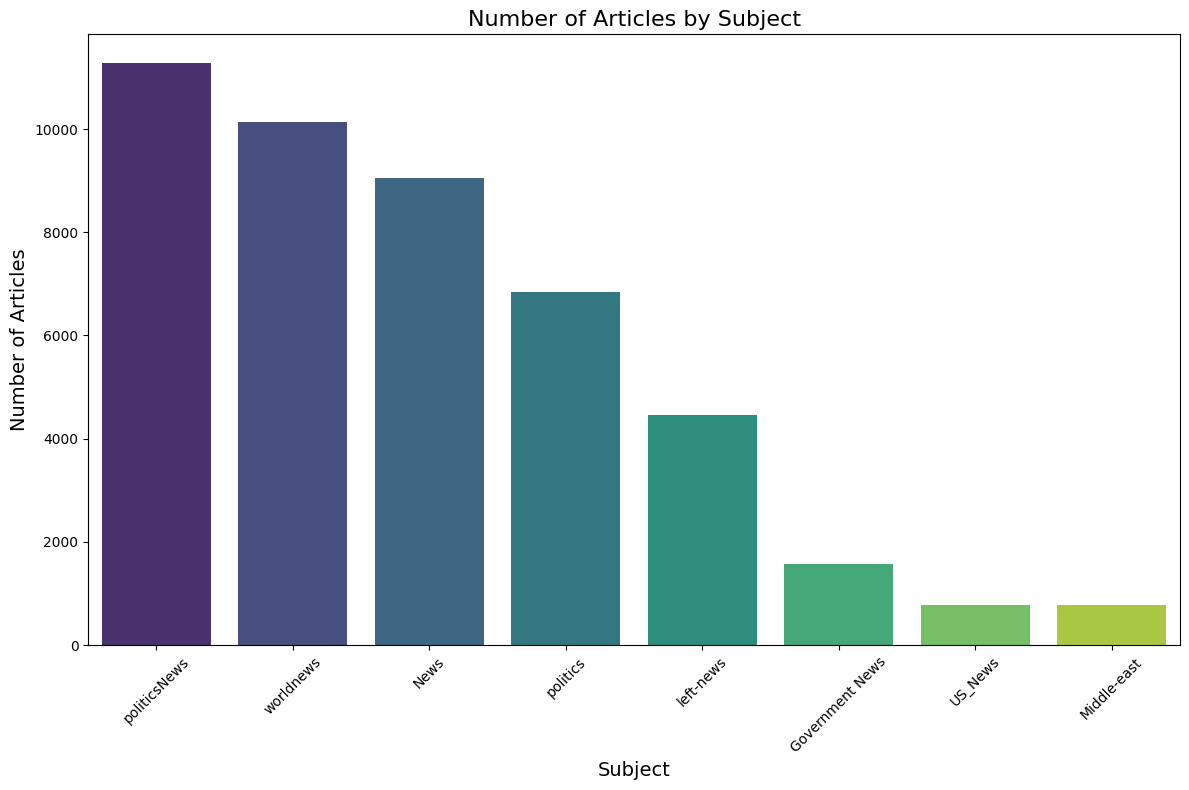

In [53]:
# Count the number of articles by subject
subject_counts = df['subject'].value_counts()
print(subject_counts)

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')
plt.title('Number of Articles by Subject', fontsize=16)
plt.xlabel('Subject', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Sentiment Analysis
False news often evokes extreme emotions, while legitimate news has a balanced tone. Machine learning models can improve accuracy by incorporating sentiment ratings into their models. This can reveal emotional language patterns, improve word choice, or focus on specific word types.Predominant Sentiment Calculation: The code identifies the predominant sentiment (positive, negative, or neutral) for each article by selecting the highest score among sentiment_pos, sentiment_neg, and sentiment_neu.

In [54]:
# Initialize sentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

#  Calculate Sentiment Scores for Each Article
df['sentiment_compound'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment_pos'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['pos'])
df['sentiment_neg'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['neg'])
df['sentiment_neu'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['neu'])

# Determine the predominant sentiment type for each article
df['predominant_sentiment'] = df[['sentiment_pos', 'sentiment_neg', 'sentiment_neu']].idxmax(axis=1)

# Count the occurrences of each sentiment type (positive, negative, neutral) by news type (Real vs Fake)
sentiment_counts_by_type = df.groupby(['label', 'predominant_sentiment']).size().unstack(fill_value=0)

# Print the counts of each predominant sentiment by news type
print("Count of articles by predominant sentiment and news type:")
print(sentiment_counts_by_type)

Count of articles by predominant sentiment and news type:
predominant_sentiment  sentiment_neg  sentiment_neu  sentiment_pos
label                                                             
0                                  2          21412              3
1                                 78          22631            772


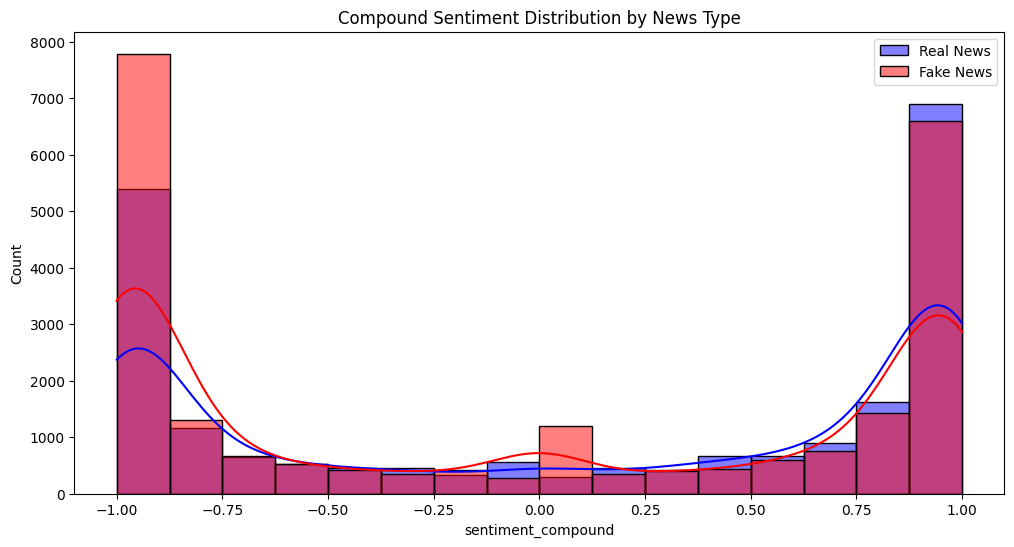

In [55]:
#  Visualize Sentiment Distributions by News Type (Fake vs Real)

# Compound Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df[df['label'] == 0]['sentiment_compound'], color='blue', label='Real News', kde=True)
sns.histplot(df[df['label'] == 1]['sentiment_compound'], color='red', label='Fake News', kde=True)
plt.title("Compound Sentiment Distribution by News Type")
plt.legend()
plt.show()

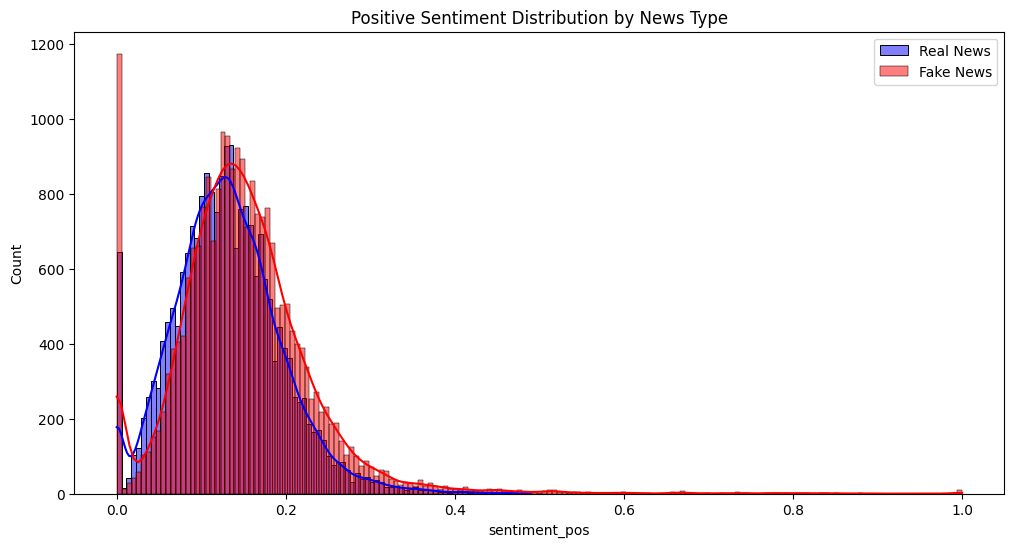

In [56]:
# Positive Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df[df['label'] == 0]['sentiment_pos'], color='blue', label='Real News', kde=True)
sns.histplot(df[df['label'] == 1]['sentiment_pos'], color='red', label='Fake News', kde=True)
plt.title("Positive Sentiment Distribution by News Type")
plt.legend()
plt.show()


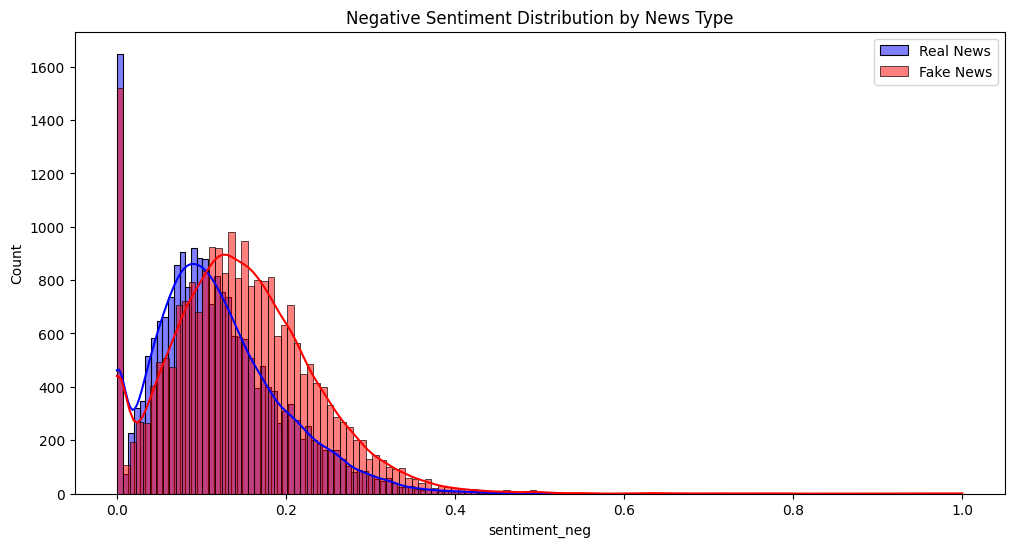

In [57]:
# Negative Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df[df['label'] == 0]['sentiment_neg'], color='blue', label='Real News', kde=True)
sns.histplot(df[df['label'] == 1]['sentiment_neg'], color='red', label='Fake News', kde=True)
plt.title("Negative Sentiment Distribution by News Type")
plt.legend()
plt.show()

label
1    23481
0    21417
Name: count, dtype: int64


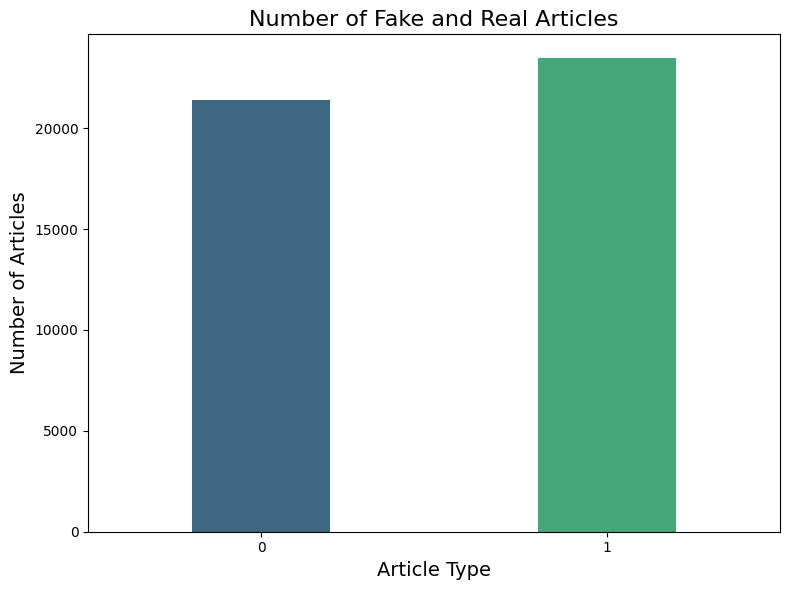

In [58]:
# How many fake and real articles?
article_counts = df['label'].value_counts()
print(article_counts)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=article_counts.index, y=article_counts.values,palette='viridis', width=0.4)
plt.title('Number of Fake and Real Articles', fontsize=16)
plt.xlabel('Article Type', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


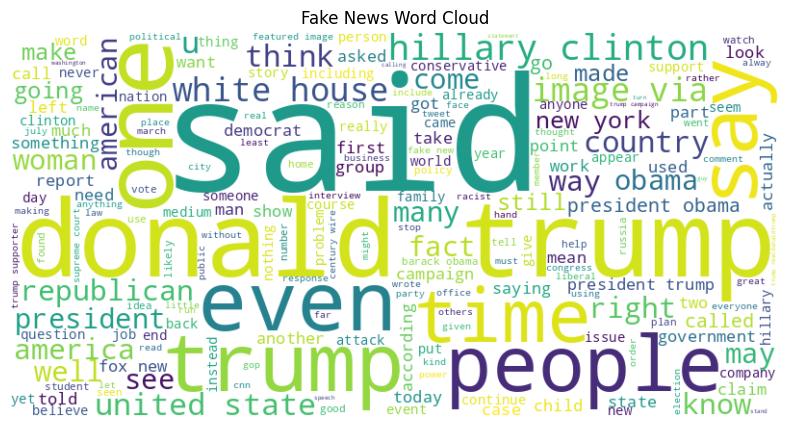

In [59]:
# Word cloud for fake news
fake_words = ' '.join(df[df['label'] == 1]['cleaned_text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')
plt.show()

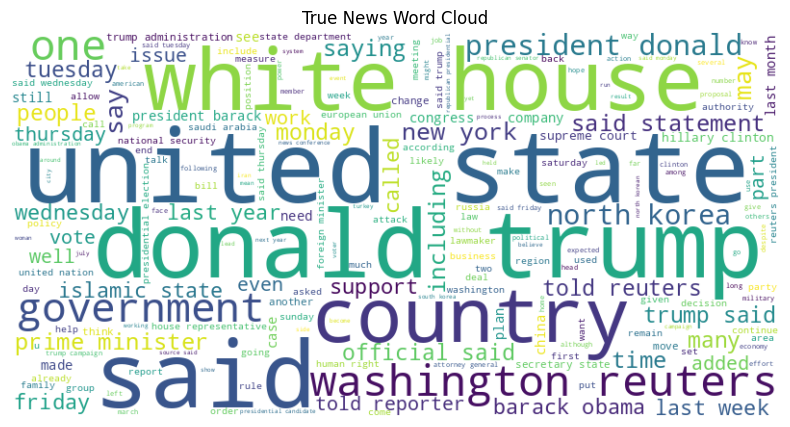

In [60]:
# Word cloud for true news

true_words = ' '.join(df[df['label'] == 0]['cleaned_text'])
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('True News Word Cloud')
plt.show()

Top 20 words in Fake News: [('trump', 74403), ('said', 31149), ('president', 26340), ('people', 26098), ('one', 23812), ('would', 23461), ('state', 22072), ('clinton', 18717), ('like', 18207), ('obama', 17920), ('time', 17885), ('donald', 17235), ('american', 16093), ('republican', 16061), ('say', 15528), ('also', 15243), ('year', 14843), ('news', 14198), ('new', 14198), ('u', 14172)]
Top 20 words in Real News: [('said', 99037), ('trump', 54280), ('state', 36243), ('would', 31526), ('reuters', 28412), ('president', 26939), ('republican', 22098), ('government', 19433), ('year', 18721), ('house', 16906), ('new', 16784), ('also', 15946), ('united', 15576), ('people', 15207), ('party', 14964), ('official', 14575), ('told', 14244), ('country', 13948), ('election', 13910), ('could', 13709)]


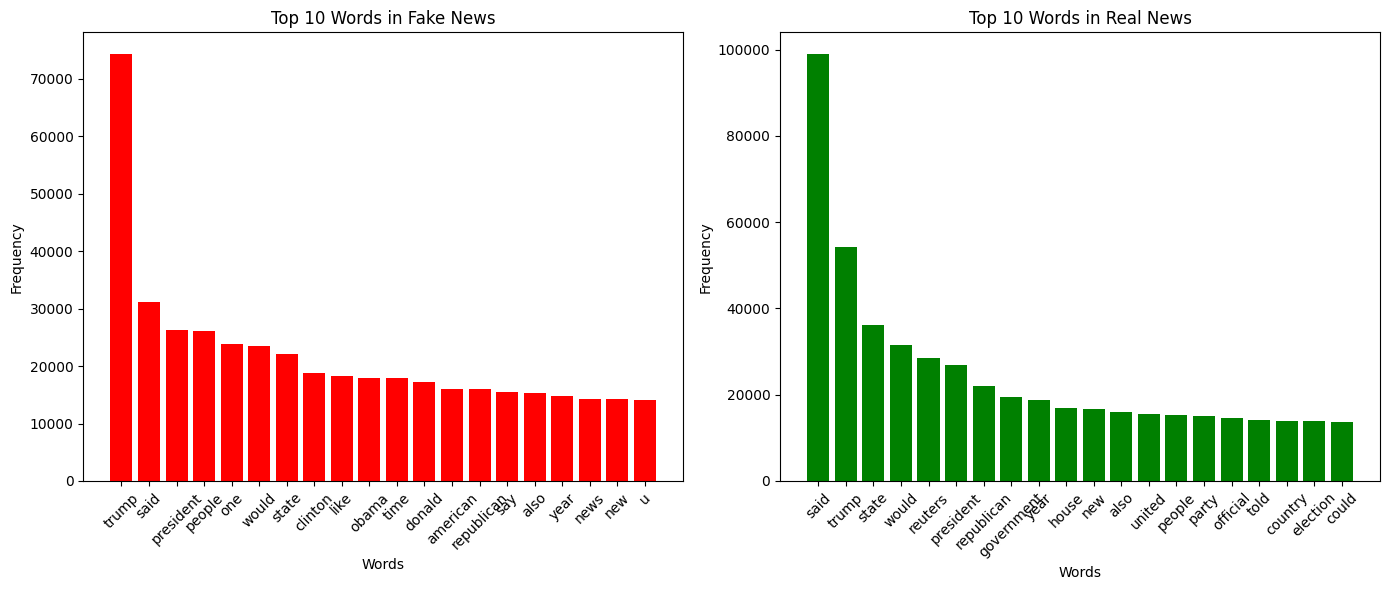

In [61]:
# Most  frequent words counter
# Fake News Word Frequency
fake_words = ' '.join(df[df['label'] == 1]['cleaned_text']).split()
counter_fake = Counter(fake_words)
top_fake = counter_fake.most_common(20)
print("Top 20 words in Fake News:", counter_fake.most_common(20))

# Real News Word Frequency
real_words = ' '.join(df[df['label'] == 0]['cleaned_text']).split()
counter_real = Counter(real_words)
top_real = counter_real.most_common(20)
print("Top 20 words in Real News:", counter_real.most_common(20))

# Unpack the top words and their counts for fake and real news
fake_words_list, fake_counts = zip(*top_fake)
real_words_list, real_counts = zip(*top_real)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Fake News Plot
axes[0].bar(fake_words_list, fake_counts, color='red')
axes[0].set_title('Top 10 Words in Fake News')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].set_xticklabels(fake_words_list, rotation=45)

# Real News Plot
axes[1].bar(real_words_list, real_counts, color='green')
axes[1].set_title('Top 10 Words in Real News')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].set_xticklabels(real_words_list, rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

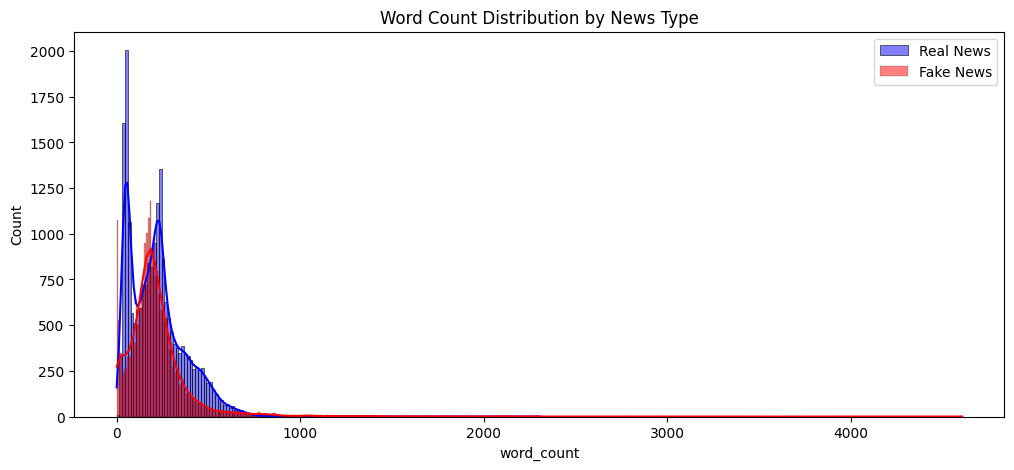

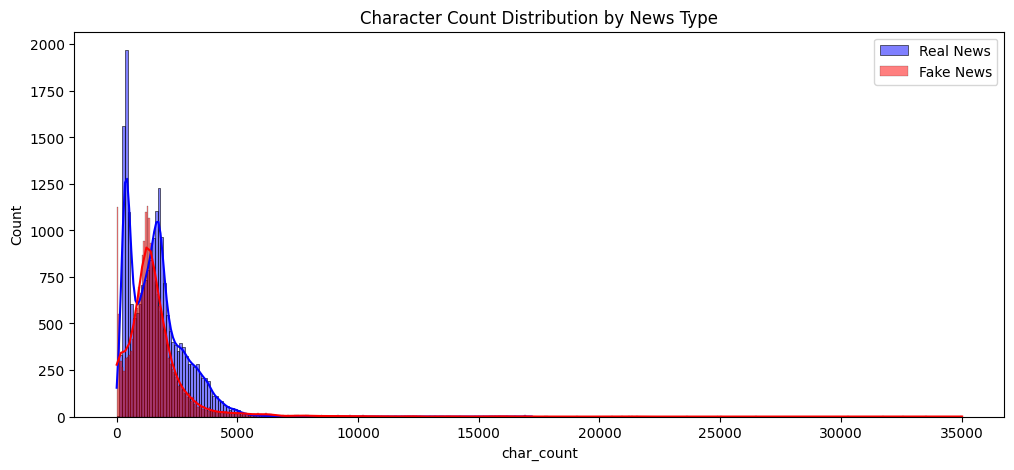

In [62]:
# Word count and sentence length analysis
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_text'].apply(len)

# Visualize word and character count distributions
plt.figure(figsize=(12, 5))
sns.histplot(df[df['label'] == 0]['word_count'], color='blue', label='Real News', kde=True)
sns.histplot(df[df['label'] == 1]['word_count'], color='red', label='Fake News', kde=True)
plt.title("Word Count Distribution by News Type")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df[df['label'] == 0]['char_count'], color='blue', label='Real News', kde=True)
sns.histplot(df[df['label'] == 1]['char_count'], color='red', label='Fake News', kde=True)
plt.title("Character Count Distribution by News Type")
plt.legend()
plt.show()

# 6. Feature Extraction
Convert the text into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency).
ngram_range=(1, 2) indicates that the TF-IDF features will contain both unigrams (single words) and bigrams (two-word combinations).
This configuration enables your model to recognise both single words and typical two-word phrases, which might be crucial for differentiating between authentic and fraudulent news.



In [63]:
# Use TF-IDF for vectorization with n-gram
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

# 7.Training & Testing Data

In [64]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

# Check the shapes of the splits
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (35918, 5000)
y_train shape: (35918,)
X_test shape: (8980, 5000)
y_test shape: (8980,)


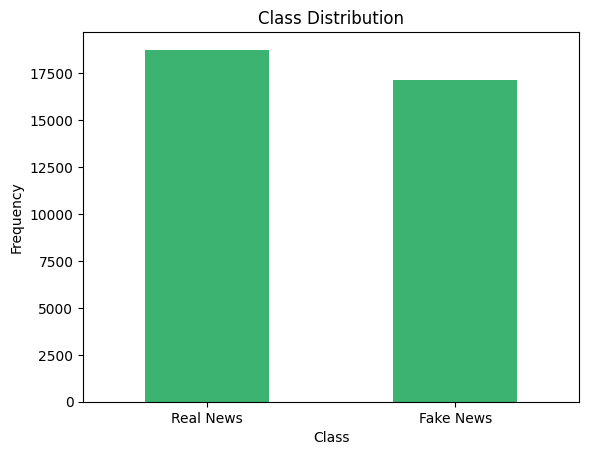

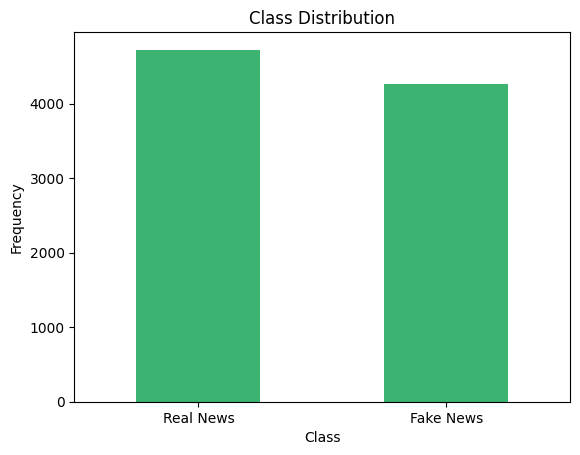

In [65]:
#. Evaluate Class Distribution
#Checking the distribution of our classes in the training and test sets:


# Plot class distribution
def plot_class_distribution(y):
    y.value_counts().plot(kind='bar', color='mediumseagreen')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(ticks=[0, 1], labels=['Real News', 'Fake News'], rotation=0)
    plt.show()

# Plot for training set
plot_class_distribution(y_train)

# Plot for test set
plot_class_distribution(y_test)


# 7. Model Training & Evaluation

Logistic Regression:
Random Forest:
Support Vector Machine:

In [69]:

# Define the three models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

In [70]:
# Train models and evaluate performance
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1] if  hasattr(model,'predict_proba') else model.decision_function(X_test))

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc}

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Logistic Regression Results:
Accuracy: 0.9896, Precision: 0.9907, Recall: 0.9896, F1 Score: 0.9901, ROC-AUC: 0.9991
Confusion Matrix:
 [[4214   44]
 [  49 4673]]

Random Forest Results:
Accuracy: 0.9976, Precision: 0.9994, Recall: 0.9960, F1 Score: 0.9977, ROC-AUC: 0.9999
Confusion Matrix:
 [[4255    3]
 [  19 4703]]

SVM Results:
Accuracy: 0.9942, Precision: 0.9949, Recall: 0.9941, F1 Score: 0.9945, ROC-AUC: 0.9997
Confusion Matrix:
 [[4234   24]
 [  28 4694]]


In [86]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:\n", results_df)


Model Performance Comparison:
                      Accuracy  Precision    Recall  F1 Score   ROC-AUC
Logistic Regression  0.989644   0.990672  0.989623  0.990147  0.999125
Random Forest        0.997550   0.999363  0.995976  0.997667  0.999938
SVM                  0.994209   0.994913  0.994070  0.994492  0.999710


# Custom Example
To check the accuracy and performance of the models i checked with  some out-of-sample-data

In [94]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample labeled test data (out-of-sample data)
sample_test_data = [
    ("Breaking: Shocking truth revealed about government secrets!", 1),  # Expected fake
    ("Scientists have confirmed that vaccines are effective against new variants.", 0),  # Expected real
    ("Experts claim that the world is flat and provide evidence to prove it.", 1),  # Expected fake
    ("The local council announced plans to improve public transportation next year.", 0),  # Expected real
    ("New research shows that drinking coffee can help you live longer.", 0),  # Expected real
    ("Aliens have been discovered living on Mars!", 1),  # Expected fake
    ("The stock market has reached an all-time high.", 0),  # Expected real
    ("Scientists have proven that the Earth is actually flat.", 1),  # Expected fake
    ("New study finds that exercise is good for mental health.", 0),  # Expected real
    ("President signs new bill to regulate social media.", 0)  # Expected real
]

# Define preprocess_text function for text cleaning
def preprocess_text(text):
    # Placeholder for text preprocessing: e.g., lowercasing, removing punctuation, etc.
    return text.lower()

# Example training data
X = [
    "Government secrets revealed!", "Vaccines are safe and effective.", "The Earth is flat!",
    "Public transportation is being improved.", "Coffee helps you live longer.",
    "Aliens are living on Mars!", "Stock market is at an all-time high.",
    "The Earth is flat!", "Exercise is good for health.", "New bill regulates social media."
]
y = [1, 0, 1, 0, 0, 1, 0, 1, 0, 0]  # Labels (1: Fake News, 0: Real News)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Function to train and test models
def train_and_test_models(X, y, sample_data, tfidf_vectorizer, preprocess_text):
    try:
        # Debug: Check if inputs are properly defined
       #print("Starting model training and testing...")

        # Check if data is empty or malformed
        if len(X) == 0 or len(y) == 0:
            print("Error: X or y is empty!")
            return

       # print("Sample Data:", sample_data[:2])  # Display first 2 samples as a check
       # print("First item in X:", X[0] if len(X) > 0 else "X is empty")
       # print("First item in y:", y[0] if len(y) > 0 else "y is empty")

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        #print("Train-test split completed.")  # Debug print

        # Fit the TF-IDF Vectorizer on the training data
        X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
        X_test_tfidf = tfidf_vectorizer.transform(X_test)
        #print("TF-IDF transformation completed.")  # Debug print
        print("Shape of X_train_tfidf:", X_train_tfidf.shape)

        # Define models
        models = {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(kernel='linear', probability=True, random_state=42)
        }

        # Define StratifiedKFold with 3 splits for better handling of imbalanced classes
        stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Train and evaluate models
        for model_name, model in models.items():
            #print(f"\nTraining {model_name} model...")  # Debug print

            # Hyperparameter tuning (optional)
            params = {'C': [0.01, 0.1, 1, 10]} if model_name in ['Logistic Regression', 'SVM'] else {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
            grid_search = GridSearchCV(model, params, cv=stratified_kfold)
            grid_search.fit(X_train_tfidf, y_train)
            model = grid_search.best_estimator_

            print(f"{model_name} training completed.")

            # Evaluate on the sample test data (out-of-sample)
            print(f"\nTesting {model_name} on Sample Data:")
            correct_predictions = 0
            for i, (text, true_label) in enumerate(sample_data):
                cleaned_text = preprocess_text(text)  # Clean the text
                transformed_text = tfidf_vectorizer.transform([cleaned_text])  # Vectorize the cleaned text
                prediction = model.predict(transformed_text)[0]

                # Check if the prediction matches the true label
                is_correct = (prediction == true_label)
                correct_predictions += is_correct
                label = 'Fake News' if prediction == 1 else 'Real News'
                actual_label = 'Fake News' if true_label == 1 else 'Real News'
                #print(f"Example {i + 1} - Predicted: {label}, Actual: {actual_label}, Correct: {is_correct}")

            accuracy = correct_predictions / len(sample_data)
            print(f"{model_name} Accuracy on Sample Data: {accuracy:.2%}")

            # Test on the entire test set (out-of-sample)
            print(f"\n{model_name} Performance on Test Set:")
            test_pred = model.predict(X_test_tfidf)
            print(classification_report(y_test, test_pred, target_names=['Real News', 'Fake News']))

        print("\nOverall Performance Summary on Test Set Completed.")
    except Exception as e:
        print("An error occurred during model training and testing:", e)


# Example usage
train_and_test_models(X, y, sample_test_data, tfidf_vectorizer, preprocess_text)


Shape of X_train_tfidf: (8, 33)
Logistic Regression training completed.

Testing Logistic Regression on Sample Data:
Logistic Regression Accuracy on Sample Data: 100.00%

Logistic Regression Performance on Test Set:
              precision    recall  f1-score   support

   Real News       1.00      0.50      0.67         2
   Fake News       0.00      0.00      0.00         0

    accuracy                           0.50         2
   macro avg       0.50      0.25      0.33         2
weighted avg       1.00      0.50      0.67         2

Random Forest training completed.

Testing Random Forest on Sample Data:
Random Forest Accuracy on Sample Data: 70.00%

Random Forest Performance on Test Set:
              precision    recall  f1-score   support

   Real News       0.00      0.00      0.00       2.0
   Fake News       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00   